In [1]:
from scipy.special import i0, k0

# Physical constants
from scipy.constants import e, h, k as k_B, pi
J_per_eV = e
BCS = 1.76

# Aluminum
N0_per_um3_per_eV = 1.72e10
tau_0 = 438e-9  # From Kaplan, which Tejas cites, but I saw 100 ns somewhere too.

In [2]:
# Device-dependent constants

# Critical temperature, in K
T_c = 1.39

# Phonon-trapping factor
F_omega = 1

# Geometry, in microns
V_um3 = 10 * 1870 # 3

# Kinetic inductance fraction, taken from Sonnet
alpha = 0.4

# Resonance frequency, in Hz
f_r = 164e6

# Inverse coupling quality factor
iQc = 1 / 50e3

# Limiting internal Q_i due to non-quasiparticle loss
iQi0 = 2e-6

# TLS spectral density at 1 Hz and reference internal power P_i_TLS, in W
S_TLS = 1e-19
P_i_TLS = 1e-13

In [3]:
# Optical system and environment

# Optical bandwidth, in Hz
bandwidth = (170 - 130) * 1e9

# Broadband center frequency, in Hz
nu_center = 150e9

# Background absorbed power, in W
P_B = 0.080e-12

# System optical efficiency (not implemented yet)
eta = 1

# Bath temperature, in K
T_bath = 0.12

# Quasiparticle temperature, in K
T_qp = T_bath

# Absorbed power, in W
P_A = np.logspace(-14.9, -10.4, 1e4)

In [4]:
# Readout parameters

# Amplifier noise temperature, in K
T_amp = 4

# Readout power in W
P_g = 1e-12

In [5]:
def gap_frequency(T_c):
    return 2 * BCS * k_B * T_c / h
    
def pair_breaking_efficiency(nu, T_c):
    nu_g = gap_frequency(T_c)
    eta_pb = nu_g / nu
    eta_pb[nu < nu_g] = 0
    eta_pb[2 * nu_g < nu] = 1 / 2
    return eta_pb

def quasiparticles_per_photon(nu, T_c):
    return 2 * pair_breaking_efficiency(nu, T_c) * nu / gap_frequency(T_c)

def S_1(f, T, T_c):
    Delta = BCS * k_B * T_c
    xi = h * f / (2 * k_B * T)
    return 2 / pi * (2 * Delta / (pi * k_B * T))**(1/2) * np.sinh(xi) * k0(xi)

def S_2(f, T, T_c):
    Delta = BCS * k_B * T_c
    xi = h * f / (2 * k_B * T)
    return 1 + (2 * Delta / (pi * k_B * T))**(1/2) * np.exp(-xi) * i0(xi)

def iQqp(f, T, T_c, V_um3, Gamma, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (2 * alpha * S_1(f, T, T_c) * N_qp(Gamma=Gamma, V_um3=V_um3) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def x(f, T, T_c, V_um3, Gamma, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (alpha * S_2(f, T, T_c) * N_qp(Gamma=Gamma, V_um3=V_um3) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def tau_qp(Gamma, V_um3):
    return N_qp(Gamma=Gamma, V_um3=V_um3) / (2 * Gamma)

def N_qp(Gamma, V_um3):
    return (V_um3 * Gamma / R_star_um3_per_s)**(1/2)

def chi_c(iQi, iQc):
    return (4 * iQi * iQc /
            (iQi + iQc)**2)

def chi_g(iQi, iQc, x):
    return (1 + 4 * x**2 * (iQi + iQc)**-2)**-1

# The default assumes that we can always tune on-resonance.
def chi_a(iQi, iQc, x=0):
    return 1 / 2 * chi_c(iQi=iQi, iQc=iQc) * chi_g(iQi=iQi, iQc=iQc, x=x)

def thermal_generation_rate(T, T_c, V_um3):
    Delta = BCS * k_B * T_c
    n_qp = 4 * (N0_per_um3_per_eV / J_per_eV) * Delta * (pi * k_B * T / (2 * Delta))**(1/2) * np.exp(-Delta / (k_B * T))
    return R_star_um3_per_s * V_um3 * n_qp**2

In [6]:
# Derived constants
print("\\Delta = {:.0f} ueV".format(1e6 * BCS * k_B * T_c / J_per_eV))

# Gap frequency
print("\\nu_g = {:.1f} GHz".format(1e-9 * gap_frequency(T_c)))

# Recombination constant
R_um3_per_s = (2 * BCS)**3 / (4 * N0_per_um3_per_eV * (BCS * k_B * T_c / J_per_eV) * tau_0)
print("R = {:.1f} um^3 s^-1".format(R_um3_per_s))

# Effective recombination constant
R_star_um3_per_s = R_um3_per_s / F_omega
print("R_* = {:.1f} um^3 s^-1".format(R_star_um3_per_s))

\Delta = 211 ueV
\nu_g = 101.9 GHz
R = 6.9 um^3 s^-1
R_* = 6.9 um^3 s^-1


For "frequency readout," the full response chain is
\begin{equation*}
\frac{\mathrm{d} S_{21}}{\mathrm{d} P_A}
  =
  \frac{\mathrm{d} S_{21}}{\mathrm{d} x}
  \frac{\mathrm{d} x}{\mathrm{d} Z_s}
  \frac{\mathrm{d} Z_s}{\mathrm{d} \sigma}
  \frac{\mathrm{d} \sigma}{\mathrm{d} N_{qp}}
  \frac{\mathrm{d} N_{qp}}{\mathrm{d} \Gamma_A}
  \frac{\mathrm{d} \Gamma_A}{\mathrm{d} P_A}.
\end{equation*}

In [7]:
# Responsivities
def d_Gamma_A_d_P_A(nu, T_c):
    if isinstance(nu, (np.ndarray, list, tuple)):
        m = quasiparticles_per_photon(nu=nu, T_c=T_c)
    else:
        m = quasiparticles_per_photon(nu=np.array([nu]), T_c=T_c)[0]
    return m / (h * nu)

def d_N_qp_d_Gamma_A(Gamma, V_um3):
    return tau_qp(Gamma=Gamma, V_um3=V_um3)

def d_iQi_d_N_qp(f, T, T_c, V_um3, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (2 * alpha * S_1(f=f, T=T, T_c=T_c) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def d_x_d_N_qp(f, T, T_c, V_um3, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (alpha * S_2(f=f, T=T, T_c=T_c) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def d_S21_d_iQi(iQi, iQc):
    return chi_c(iQi=iQi, iQc=iQc) / (4 * iQi)

def d_S21_d_x(iQi, iQc):
    return 1j * chi_c(iQi=iQi, iQc=iQc) / (2 * iQi)

# NEP

For a given absorbed power $P_A$, calculate 

In [8]:
def NEP2_photon_simple(P_A, P_B, nu, bandwidth):
    return 2 * h * nu * (P_A + P_B) + 2 * P_A**2 / bandwidth


def NEP2_photon(Gamma_A, Gamma_B, nu, T_c, bandwidth):
    m = quasiparticles_per_photon(nu=np.array([nu]), T_c=T_c)[0]
    S_Gamma = 2 * m * Gamma_A * (1 + Gamma_A / (m * bandwidth)) + 4 * Gamma_B
    return S_Gamma / d_Gamma_A_d_P_A(nu=nu, T_c=T_c)**2


def NEP2_recombination(Gamma, nu, T_c):
    """Gamma is the total generation rate, including all sources."""
    return 4 * Gamma / d_Gamma_A_d_P_A(nu=nu, T_c=T_c)**2


def NEP2_TLS(S_TLS, Gamma, nu, P_i):
    return ((S_TLS * (P_i_TLS / P_i)**(1/2)) /
            (d_x_d_N_qp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, alpha=alpha) *
             d_N_qp_d_Gamma_A(Gamma=Gamma, V_um3=V_um3) *
             d_Gamma_A_d_P_A(nu=nu, T_c=T_c))**2)


def NEP2_amp(T_amp, P_g, Gamma, nu, iQi, iQc, alpha):
    return ((k_B * T_amp / P_g) /
            (np.abs(d_S21_d_x(iQi=iQi, iQc=iQc)) * 
             d_x_d_N_qp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, alpha=alpha) *
             d_N_qp_d_Gamma_A(Gamma=Gamma, V_um3=V_um3) *
             d_Gamma_A_d_P_A(nu=nu, T_c=T_c))**2)

In [9]:
m_center = quasiparticles_per_photon(np.array([nu_center]), T_c)[0]
print("m_center = {:.2f}".format(m_center))
Gamma_A = m_center * P_A / (h * nu_center)
print("{:.2g} s^-1 <= Gamma_A <= {:.2g} s^-1".format(Gamma_A[0], Gamma_A[-1]))
Gamma_B = m_center * P_B / (h * nu_center)
print("Gamma_B = {:.2g} s^-1".format(Gamma_B))
Gamma_t = thermal_generation_rate(T=T_bath, T_c=T_c, V_um3=V_um3)
print("Gamma_t = {:.2g} s^-1".format(Gamma_t))
Gamma = Gamma_A + Gamma_B + Gamma_t

m_center = 2.00
2.5e+07 s^-1 <= Gamma_A <= 8e+11 s^-1
Gamma_B = 1.6e+09 s^-1
Gamma_t = 4.1 s^-1


In [10]:
# Plot parameters
P_A_scale = 1e12
photon_color = 'red'
recombination_color = 'blue'
amp_color = 'gray'
TLS_color = 'brown'
nonphoton_color = 'green'
total_color = 'black'

In [11]:
# Calculate the actual Q and NEP values:
iQi = iQi0 + iQqp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha)

photon = NEP2_photon(Gamma_A, Gamma_B, nu_center, T_c, bandwidth)
recombination = NEP2_recombination(Gamma, nu_center, T_c)
amplifier = NEP2_amp(T_amp=T_amp, P_g=P_g, Gamma=Gamma, nu=nu_center, iQi=iQi, iQc=iQc, alpha=alpha)
TLS = NEP2_TLS(S_TLS=S_TLS, Gamma=Gamma, nu=nu_center, P_i=chi_a(iQi=iQi, iQc=iQc)*P_g)
nonphoton = recombination + amplifier + TLS
total = photon + recombination + amplifier + TLS

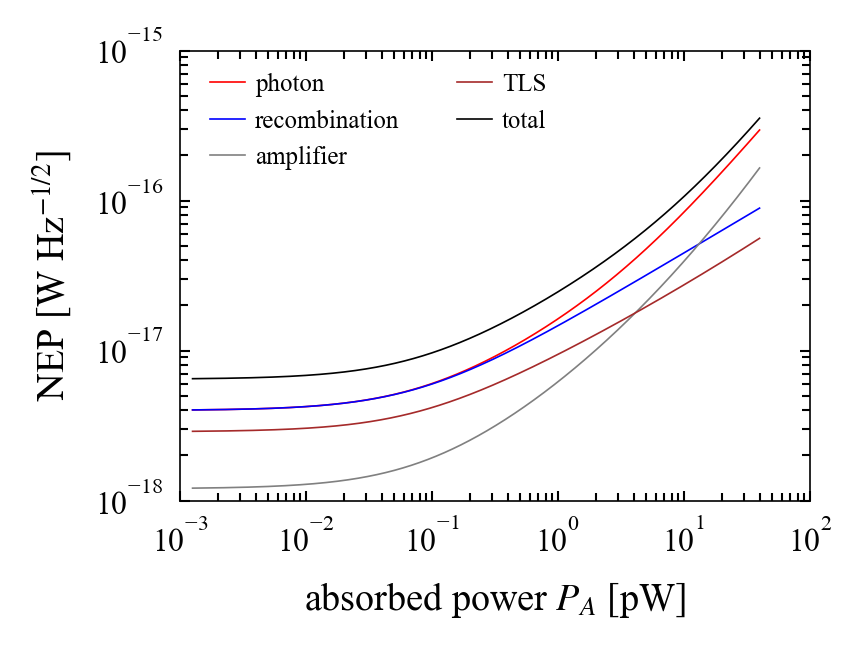

In [12]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('NEP [W Hz$^{-1/2}$]')

ax.plot(P_A_scale * P_A,
        photon**(1/2),
        color=photon_color, label='photon')

ax.plot(P_A_scale * P_A,
        recombination**(1/2),
        color=recombination_color, label='recombination')

ax.plot(P_A_scale * P_A,
        amplifier**(1/2),
        color=amp_color, label='amplifier')

ax.plot(P_A_scale * P_A,
        TLS**(1/2),
        color=TLS_color, label='TLS')

"""
ax.plot(P_A_scale * P_A,
        nonphoton**(1/2),
        color=nonphoton_color, label='total - photon')
"""

ax.plot(P_A_scale * P_A,
        total**(1/2),
        color=total_color, label='total')

ax.legend(loc='upper left', fontsize=6, ncol=2);

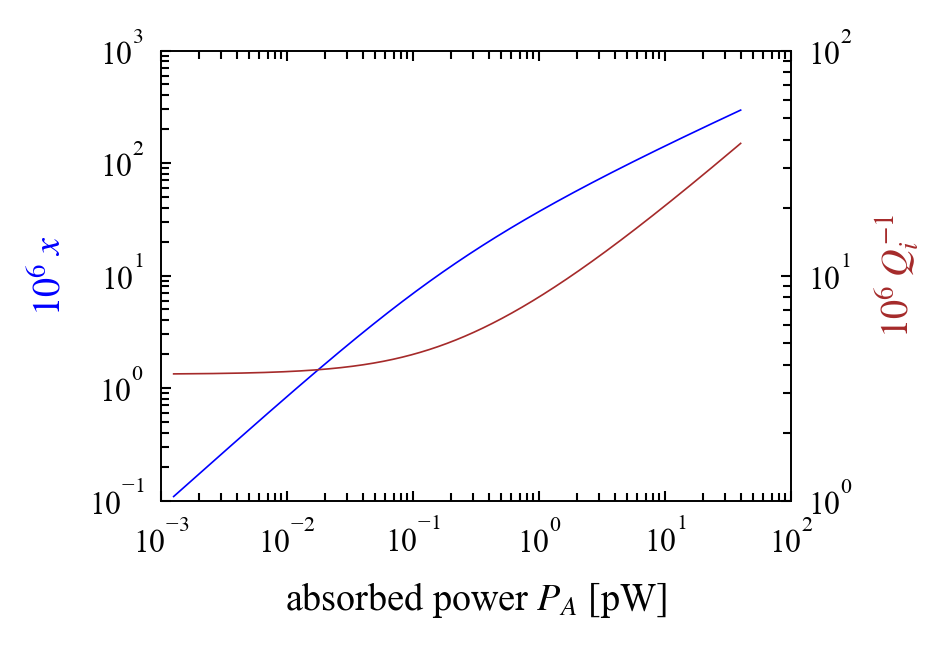

In [13]:
x_color = 'blue'
iQi_color = 'brown'

fig, x_ax = plt.subplots()
iQi_ax = x_ax.twinx()

x_ax.set_xscale('log')
x_ax.set_yscale('log')
iQi_ax.set_yscale('log')
x_ax.set_xlabel('absorbed power $P_A$ [pW]')
x_ax.set_ylabel('$10^6 \; x$', color=x_color)
iQi_ax.set_ylabel('$10^6 \; Q_i^{-1}$', color=iQi_color)

x_ax.plot(P_A_scale * P_A,
            1e6 * (x(f=f_r, T=T_qp, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha) -
                   x(f=f_r, T=T_qp, T_c=T_c, V_um3=V_um3, Gamma=Gamma_B, alpha=alpha)),
            color=x_color)

iQi_ax.plot(P_A_scale * P_A,
            1e6 * (iQqp(f=f_r, T=T_qp, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha) + iQi0),
            color=iQi_color)


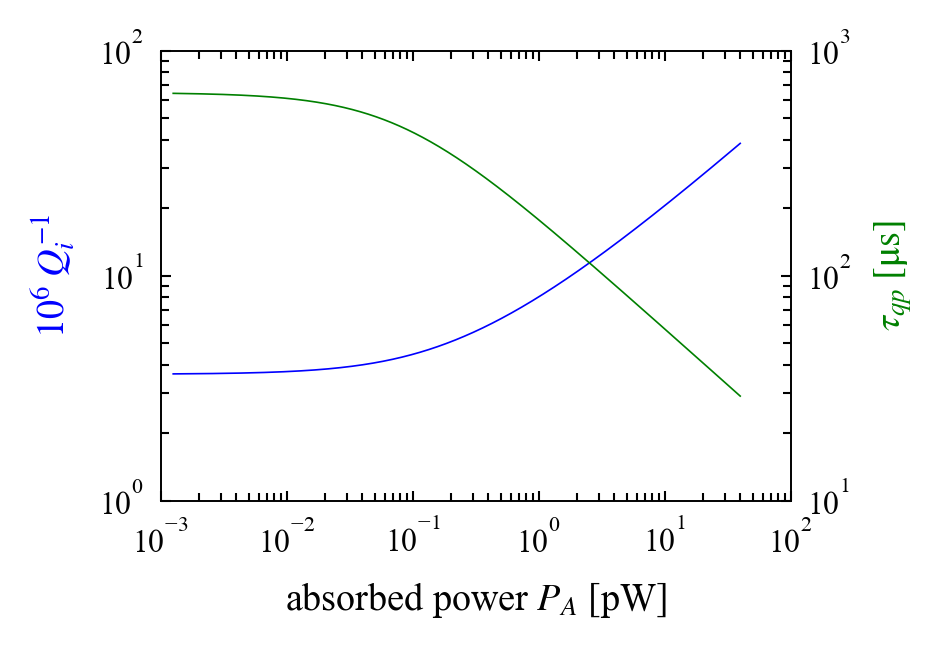

In [14]:
iQi_color = 'blue'
tau_qp_color = 'green'

fig, iQi_ax = plt.subplots()
tau_qp_ax = iQi_ax.twinx()

iQi_ax.set_xscale('log')
iQi_ax.set_yscale('log')
tau_qp_ax.set_yscale('log')
iQi_ax.set_xlabel('absorbed power $P_A$ [pW]')
iQi_ax.set_ylabel('$10^6 \; Q_i^{-1}$', color=iQi_color)
tau_qp_ax.set_ylabel(r'$\tau_{qp} \; [\mathrm{\mu s}]$', color=tau_qp_color)

iQi_ax.plot(P_A_scale * P_A,
            1e6 * (iQqp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha) + iQi0),
            color=iQi_color)

tau_qp_ax.plot(P_A_scale * P_A,
               1e6 * tau_qp(Gamma=Gamma, V_um3=V_um3),
               color=tau_qp_color)


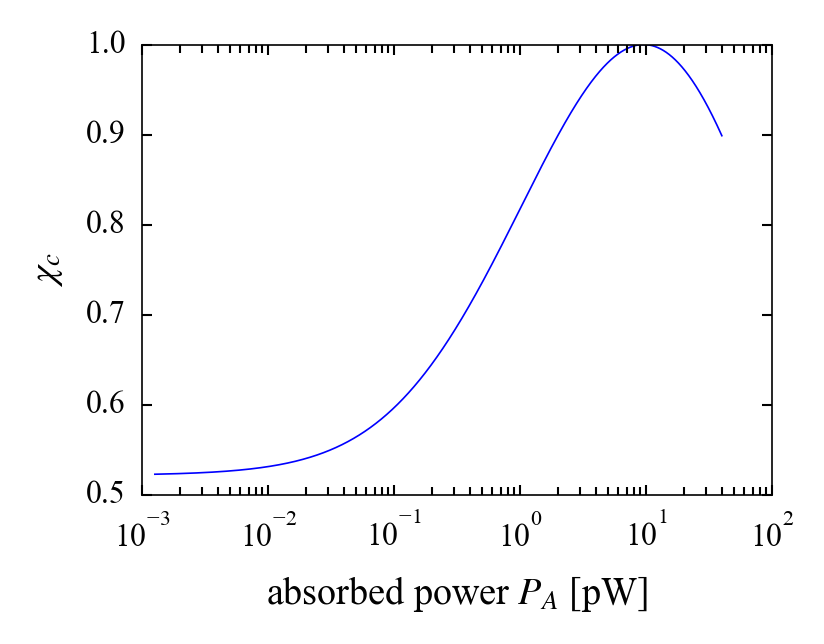

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel(r'$\chi_c$')
ax.semilogx(P_A_scale * P_A,
        chi_c(iQi=iQi, iQc=iQc))

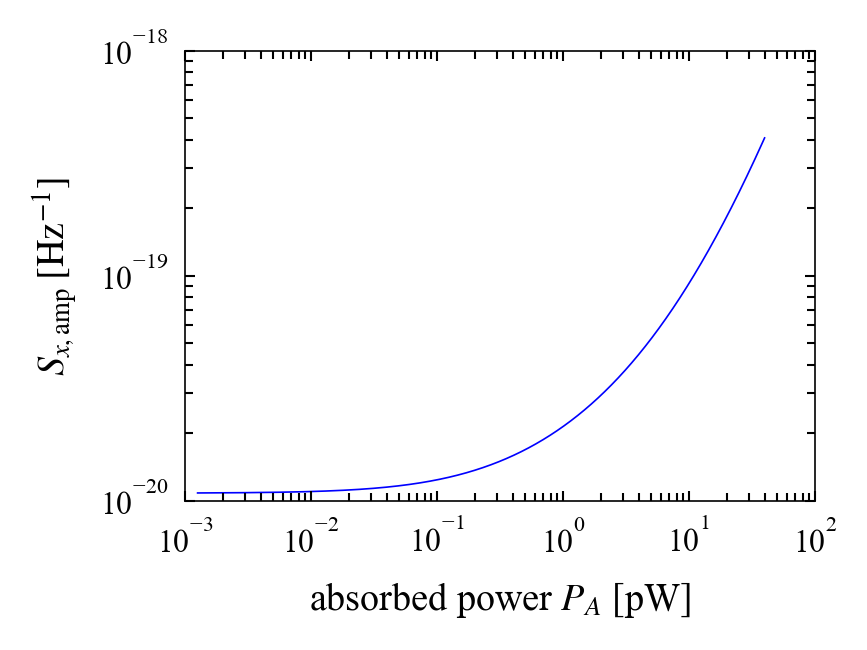

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel(r'$S_{x, \mathrm{amp}} \; [\mathrm{Hz}^{-1}]$')

ax.loglog(P_A_scale * P_A,
          (k_B * T_amp / P_g) / np.abs(d_S21_d_x(iQi=iQi, iQc=iQc))**2)

# Generation efficiency

In [17]:
nu = np.linspace(0, 4 * gap_frequency(T_c), 1e3)
nu = nu[1:]

In [18]:
eta_color = 'blue'
m_color = 'green'

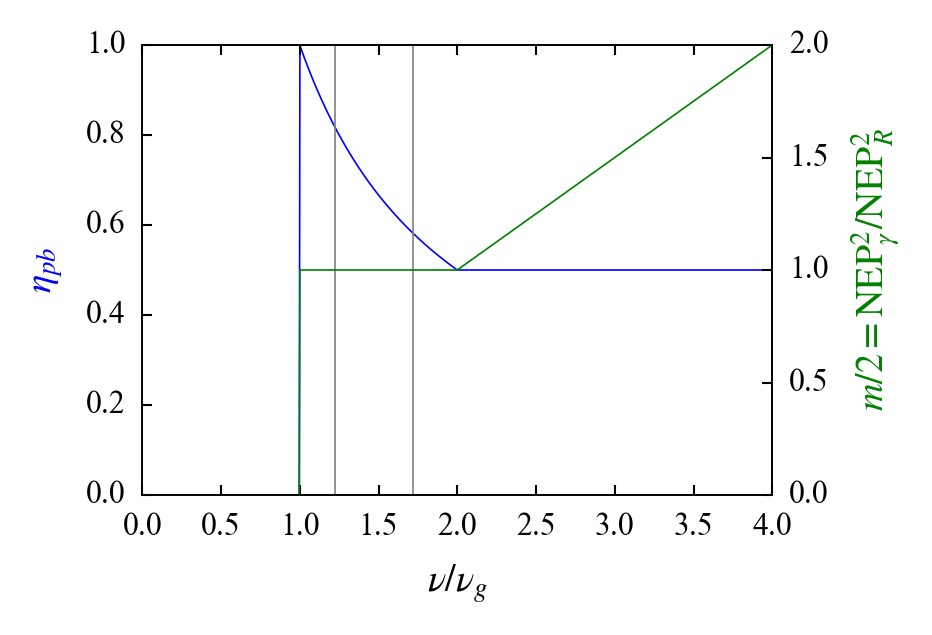

In [19]:
fig, eta_ax = plt.subplots()
m_ax = eta_ax.twinx()

eta_ax.plot(nu / gap_frequency(T_c), pair_breaking_efficiency(nu, T_c),
            color=eta_color)
eta_ax.set_xlabel(r'$\nu / \nu_g$')
eta_ax.set_ylabel(r'$\eta_{pb}$', color=eta_color)
m_ax.plot(nu / gap_frequency(T_c), quasiparticles_per_photon(nu, T_c) / 2,
          color=m_color)
m_ax.set_ylabel('$m / 2 = \mathrm{NEP}_\gamma^2 / \mathrm{NEP}_R^2$',
                color=m_color)

eta_ax.axvline(125e9 / gap_frequency(T_c), color='gray')
eta_ax.axvline(175e9 / gap_frequency(T_c), color='gray')

#fig.savefig('/Users/daniel/Desktop/eta_pb_and_m_vs_frequency.pdf', bbox_inches='tight')